## 1. Structure Dataset

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

# funcs stolen from nyu deep learning course
from res.sequential_tasks import pad_sequences, to_categorical


In [4]:
# load train and test datasets...

train_data_file_path = 'simulated_data/train_data_v1.0.json'
train_data_file = open(train_data_file_path)
train_data_sim = json.load(train_data_file)

test_data_file_path = 'simulated_data/test_data_v1.0.json'
test_data_file = open(test_data_file_path)
test_data_sim = json.load(test_data_file)

# see this for loading just part of a json if we run into memory issues
# https://stackoverflow.com/questions/32661646/load-part-of-a-json-in-python

# sim_data is a list of dicts
# each dict has 'values' (3x1), fixations (many lengths), and choice (1)

In [5]:
def gen_batch_data(batch_size, batch_idx, sim_data):
    
    """
    Create sequence and target data for a batch
    
    Input: 
        batch_size: number of trials to include in batch
        batch_idx: index of data
        sim_data: list of dicts, where each dict has 'values', 'fixations', and 'choice'
        
    Returns:
        a tuple, (batch_data, batch_targets)
        batch_data is 3d array: batch_size x sequence_size x one-hot categorical encoding (3 here)
        batch_targets is 2d array: 
    """

    # filter list of trials that are in this batch
    batch_sim_data = sim_data[batch_idx*batch_size:((batch_idx+1)*(batch_size))]
    
    ## generate sequences of fixations + choice

    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    batch_sequences_idx = [trial_data['fixations'] + [trial_data['choice']] for trial_data in batch_sim_data]

    # all sequences in the batch, attended item coded as one-hot categorical: e.g. 0: [1,0,0] 1: [0,1,0], [0,0,1]
    batch_sequences_cat = [[to_categorical(x, num_classes = 3) for x in this_sequence] for this_sequence in batch_sequences_idx]

    # pad front of each sequence with n x [0,0,0] so that all seqeunces are same length
    batch_data = pad_sequences(batch_sequences_cat)
    batch_data = batch_data.astype('float32')


    ## generate sequences of targets
    batch_targets = np.array([trial_data['values'] for trial_data in batch_sim_data], dtype = 'float32')
    
    return (batch_data, batch_targets)

In [6]:
example_batch = gen_batch_data(32, 0, train_data_sim) # batch size = 32, idx = 0
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of targets is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 23, 3).
The first element in the batch of sequences is:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 3).
The first element in the batch of targets is:
 [5. 6. 3.]


## 2. Defining the Model

In [7]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x
    
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

## 3. Defining the Training Loop

In [8]:
def train(model, train_sim_data, criterion, optimizer, device, batch_size, n_total_seq):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # What metric to store?
    # num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
        
    # how many batches
    n_batches = int(np.round(n_total_seq/batch_size));
    
    for batch_idx in range(n_batches):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        #data, target = train_data_gen[batch_idx] # just alter this to the function that produces the data?
        data, target = gen_batch_data(batch_size, batch_idx, train_sim_data)
        
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        
        # for some reason target is an int, and dosn't match the output which is float32
        target = target.to(torch.float32)
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤
        
        #y_pred = output.argmax(dim=1)
        
        # this is wrong since we're doing regression...
        #num_correct += (y_pred == target).sum().item()

    #return num_correct, loss.item()
    return loss.item()

## 4. Defining the Testing Loop

In [9]:
def test(model, test_sim_data, criterion, device, batch_size, n_total_seq):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    # num_correct = 0
    
    n_batches = int(np.round(n_total_seq/batch_size));

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            #target = target.argmax(dim=1)
            loss = criterion(output, target)

            # y_pred = output.argmax(dim=1)
            # num_correct += (y_pred == target).sum().item()

    #return num_correct, loss.item()
    return loss.item()

In [30]:
def train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = ''):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    # history_train = {'loss': [], 'acc': []}
    # history_test = {'loss': [], 'acc': []}
    
    history_train = {'loss': []}
    history_test = {'loss': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        #num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        loss = train(model, train_data_sim, criterion, optimizer, device, batch_size, n_total_seq)
        # accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        # history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        # num_correct, loss = test(model, test_data_gen, criterion, device)
        loss = test(model, test_data_sim, criterion, device, batch_size, n_total_seq)
        history_test['loss'].append(loss)

        if (verbose & (epoch % 10 == 0)) or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f} (MSE)"
                  f" - test_loss: {history_test['loss'][-1]:.4f} (MSE)")

    # Generate diagnostic plots for the loss and accuracy
    fig, ax = plt.subplots(1, figsize=(4.4, 4.5))
    #for ax, metric in zip(axes, ['loss', 'acc']):
    ax.plot(history_train['loss'])
    ax.plot(history_test['loss'])
    ax.set_xlabel('epoch', fontsize=12)
    ax.set_ylabel('loss (MSE)', fontsize=12)
    ax.legend(['Train', 'Test'], loc='best')
    ax.set_title(model_name)
    plt.show()

    return model

## Run the RNN!

[Epoch 1/200] loss: 34.3984 (MSE) - test_loss: 26.6356 (MSE)
[Epoch 11/200] loss: 7.6758 (MSE) - test_loss: 6.7719 (MSE)
[Epoch 21/200] loss: 5.9124 (MSE) - test_loss: 5.7606 (MSE)
[Epoch 31/200] loss: 4.8954 (MSE) - test_loss: 5.1087 (MSE)
[Epoch 41/200] loss: 4.5552 (MSE) - test_loss: 4.8844 (MSE)
[Epoch 51/200] loss: 4.2105 (MSE) - test_loss: 4.6412 (MSE)
[Epoch 61/200] loss: 3.8478 (MSE) - test_loss: 4.4032 (MSE)
[Epoch 71/200] loss: 3.4732 (MSE) - test_loss: 4.1833 (MSE)
[Epoch 81/200] loss: 3.1071 (MSE) - test_loss: 3.9802 (MSE)
[Epoch 91/200] loss: 2.7741 (MSE) - test_loss: 3.7711 (MSE)
[Epoch 101/200] loss: 2.5069 (MSE) - test_loss: 3.5919 (MSE)
[Epoch 111/200] loss: 2.3249 (MSE) - test_loss: 3.4382 (MSE)
[Epoch 121/200] loss: 2.2147 (MSE) - test_loss: 3.3195 (MSE)
[Epoch 131/200] loss: 2.1337 (MSE) - test_loss: 3.2237 (MSE)
[Epoch 141/200] loss: 2.0652 (MSE) - test_loss: 3.1467 (MSE)
[Epoch 151/200] loss: 1.9981 (MSE) - test_loss: 3.0841 (MSE)
[Epoch 161/200] loss: 1.9421 (MSE

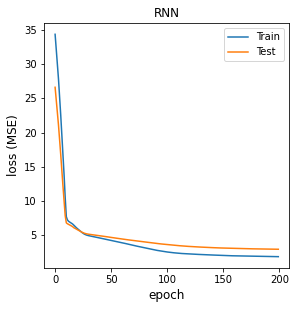

--- 45.02032732963562 seconds ---


In [21]:
import time

# Setup the training and test data generators
batch_size     = 32
n_total_seq = 1000

# Setup the RNN and training settings
input_size  = 3 # this is the length of the input vector? #train_data_gen.n_symbols
hidden_size = 4
output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 200

# Train the model
# model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

start_time = time.time()
model_RNN = train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = 'RNN')
print("--- %s seconds ---" % (time.time() - start_time))


## Run the LSTM

[Epoch 1/100] loss: 7.3905 (MSE) - test_loss: 7.4434 (MSE)
[Epoch 11/100] loss: 0.6482 (MSE) - test_loss: 0.6070 (MSE)
[Epoch 21/100] loss: 0.1151 (MSE) - test_loss: 0.1292 (MSE)
[Epoch 31/100] loss: 0.0814 (MSE) - test_loss: 0.0946 (MSE)
[Epoch 41/100] loss: 0.0637 (MSE) - test_loss: 0.0762 (MSE)
[Epoch 51/100] loss: 0.0431 (MSE) - test_loss: 0.0494 (MSE)
[Epoch 61/100] loss: 0.0558 (MSE) - test_loss: 0.0412 (MSE)
[Epoch 71/100] loss: 0.0216 (MSE) - test_loss: 0.0263 (MSE)
[Epoch 81/100] loss: 0.0171 (MSE) - test_loss: 0.0220 (MSE)
[Epoch 91/100] loss: 0.0166 (MSE) - test_loss: 0.0149 (MSE)
[Epoch 100/100] loss: 0.0047 (MSE) - test_loss: 0.0143 (MSE)


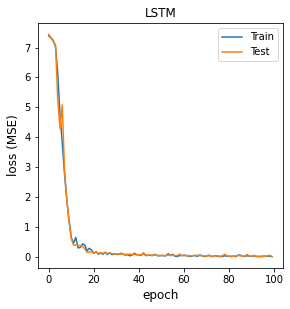

--- 53.27911162376404 seconds ---


In [31]:
# Setup the training and test data generators
batch_size     = 32
n_total_seq = 1000

# Setup the RNN and training settings
input_size  = 3 # this is the length of the input vector? #train_data_gen.n_symbols
hidden_size = 100
output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
# model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)
start_time = time.time()
model_LSTM = train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = 'LSTM')
print("--- %s seconds ---" % (time.time() - start_time))

In [307]:
def test_record_each_output(model, test_sim_data, criterion, device, batch_size, n_total_seq):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    # num_correct = 0

    n_batches = int(np.round(n_total_seq/batch_size));

    output_all = np.zeros((0,3))
    target_all = np.zeros((0,3))


    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            output_all = np.concatenate((output_all, output.numpy()))
            target_all = np.concatenate((target_all, target.numpy()))

    return (output_all, target_all)

        #target = target.argmax(dim=1)
        #loss = criterion(output, target)

            # y_pred = output.argmax(dim=1)
            # num_correct += (y_pred == target).sum().item()

    #return num_correct, loss.item()
    #return loss.item()

Text(0.5, 1.0, 'RNN performance')

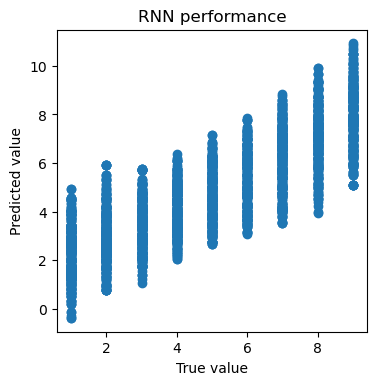

In [331]:
output_all_RNN, target_all_RNN = test_record_each_output(model_RNN, test_sim_data, criterion, device, batch_size, n_total_seq)
fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(target_all_RNN.flatten(), output_all_RNN.flatten(), 'o')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted value')
ax.set_title('RNN performance')

Text(0.5, 1.0, 'LSTM performance')

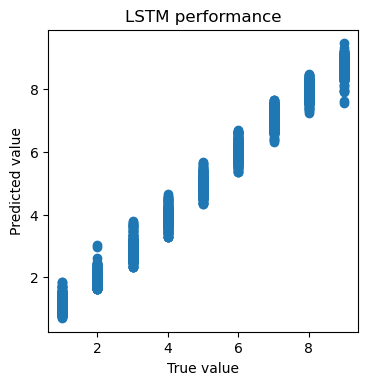

In [329]:
output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM, test_sim_data, criterion, device, batch_size, n_total_seq)
fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(target_all_LSTM.flatten(), output_all_LSTM.flatten(), 'o')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted value')
ax.set_title('LSTM performance')